In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
import pandas as pd

In [3]:
from transformer_utils import DataProcessor
import model
import utils
import pipeline

c:\users\e516977\.virtualenvs\teampcamp2019-vtq4pcez\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\e516977\.virtualenvs\teampcamp2019-vtq4pcez\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\e516977\.virtualenvs\teampcamp2019-vtq4pcez\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c

In [4]:
data_path = "data"

In [5]:
do_lower_case=False,
max_seq_length = 128

In [6]:
processor = DataProcessor()
train_examples = processor.get_train_examples(data_path)

In [7]:
txt_dataset = pd.DataFrame([(e.label, e.text_a) for e in train_examples], columns=("label", "text"))

txt_dataset.label.value_counts().plot(kind="bar")

In [8]:
model_path = "./trained/"

In [9]:
bert_model, tokenizer = utils.load_model(model_path, do_lower_case=True)

2019-09-06 11:43:15,075 : INFO : Loading model from ./trained/
2019-09-06 11:43:15,077 : INFO : loading configuration file ./trained/config.json
2019-09-06 11:43:15,078 : INFO : Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 9,
  "output_attentions": false,
  "output_hidden_states": true,
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 30000
}

2019-09-06 11:43:15,079 : INFO : loading weights file ./trained/pytorch_model.bin
2019-09-06 11:43:17,402 : INFO : Model name './trained/' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese, ber

In [10]:
import numpy as np
import torch

In [11]:
def predict(feature_tensors, bert_model, batch_size):
    device = model.get_device()
    
    all_input_ids, all_input_mask, all_segment_ids, all_label_ids = feature_tensors
    
    preds = None
    for i in range(0, len(feature_tensors[0]), batch_size):
        bert_model.eval()
        with torch.no_grad():
            _, logits, _ = bert_model(input_ids=all_input_ids[i:(i+batch_size)].to(device), 
                                   attention_mask=all_input_mask[i:(i+batch_size)].to(device), 
                                   token_type_ids=all_segment_ids[i:(i+batch_size)].to(device), 
                                   labels=all_label_ids[i:(i+batch_size)].to(device)
                                  )
            if preds is None:
                preds = logits.detach().cpu().numpy()
            else:
                preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)

    return np.argmax(preds, axis=1)

In [12]:
features = pipeline.build_features(train_examples[:800], processor.get_labels(), max_seq_length, tokenizer)
feature_tensors = pipeline.convert_to_tensors(features)

In [13]:
preds = predict(feature_tensors, bert_model, 8)

In [14]:
labels = feature_tensors[3].detach().cpu().numpy()

In [15]:
model.compute_metrics(preds, labels)

{'acc': 0.7575,
 'f1_micro': 0.7575,
 'f1_macro': 0.7450324114693911,
 'acc_and_f1': 0.7575}

In [16]:
from transformer_utils import InputExample

In [17]:
def create_tensors_from_text(texts):
    examples = [InputExample(guid=str(i), text_a=text, text_b=None, label=processor.get_labels()[0]) for i, text in enumerate(texts)]
    features = pipeline.build_features(examples, processor.get_labels(), max_seq_length, tokenizer)
    feature_tensors = pipeline.convert_to_tensors(features)
    
    return feature_tensors

In [18]:
def compute_embeddings(texts, bert_model, batch_size):
    feature_tensors = create_tensors_from_text(texts)
    
    
    device = model.get_device()
    
    all_input_ids, all_input_mask, all_segment_ids, all_label_ids = feature_tensors
    
    hidden_state_list = None
    
    bert_model.eval()
    for i in range(0, len(feature_tensors[0]), batch_size):
        with torch.no_grad():
            _, _, hidden_states = bert_model(input_ids=all_input_ids[i:(i+batch_size)].to(device), 
                                   attention_mask=all_input_mask[i:(i+batch_size)].to(device), 
                                   token_type_ids=all_segment_ids[i:(i+batch_size)].to(device), 
                                   labels=all_label_ids[i:(i+batch_size)].to(device)
                                  )
            if hidden_state_list is None:
                hidden_state_list = np.array([hs.detach().cpu().numpy() for hs in hidden_states])
            else:
                hidden_state_list = np.append(hidden_state_list, [hs.detach().cpu().numpy() for hs in hidden_states], axis=1)
            

    return hidden_state_list

In [19]:
texts = ["Die Prinzessin wohnt im prunkvollen Schloss", 
         "Das Schloss wurde im Mittelalter erbaut",
         "Die Türe benötigt dringend ein neue Schloss",
         "Das Schloss der Kiste ist schon lange defekt"]

keyword = "Schloss"

In [20]:
hidden_states = compute_embeddings(texts, bert_model, 8)

In [21]:
last_layer = hidden_states[-1]


In [22]:
for idx, text in enumerate(texts):
    print(text)
    tokens_a = tokenizer.tokenize(text)
    for (token, embeddings) in zip(tokens_a, last_layer[idx]):
        print(token, embeddings[: 10], "...")
    print()

Die Prinzessin wohnt im prunkvollen Schloss
die [ 0.19949171  0.6674701  -0.4995471   0.22821465  0.57511127  0.12204019
 -0.7050208   0.3042269   0.04609396 -0.0800918 ] ...
pri [-0.932495    0.21440175 -0.47336107 -0.31614128 -0.30238453 -0.77146244
 -0.78952646  0.5519063  -0.3136775   0.73738176] ...
##n [ 1.1446395   0.48982182 -0.12486835  0.78828937 -0.6064     -0.03958548
  0.75160134  0.48527676  0.29800606  1.5452099 ] ...
##zessin [-0.31543308 -0.24068704 -0.7447281  -0.07043762  0.03576417 -0.7025688
  0.14945623  0.92424476 -1.6836517   0.5431963 ] ...
wohnt [ 0.35671628 -0.05010961  0.26379323 -0.3007524   0.36181685  0.45295185
  0.28822708  0.172923   -0.5302089   0.48997465] ...
im [-0.14864717 -0.2152715  -0.45718277 -0.4548815   0.01706519 -0.157309
 -0.55180657  0.20091227 -0.02222855  0.3747477 ] ...
p [-0.09267059  0.43038243 -0.36094072  0.33853942  0.4785929  -0.40772754
 -0.67258644  0.7538942   0.3010658   0.29157805] ...
##run [ 0.20806953  0.10386507 -0.9707

In [23]:
def embeddings_for_keyword(texts, keyword):
    return np.vstack([last_layer[i, 1+tokenizer.tokenize(text).index(keyword.lower())] for i, text in enumerate(texts)])
    #return sequene_embeddings[[tokenizer.tokenize(text).index(keyword.lower()) for text in texts]]

In [24]:
def token_embeddings_for_sequence(texts):
    return np.vstack([last_layer[i, 1:len(tokenizer.tokenize(text))+1] for i,text in enumerate(texts)])

In [25]:
def sentence_embedding_for_sentence(text):
    return np.vstack([last_layer[i, 1] for i,_ in enumerate(texts)])    

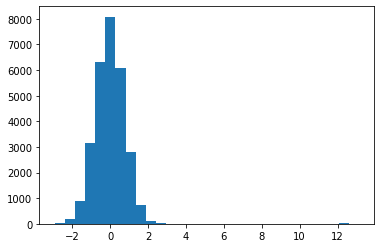

In [27]:
_ = plt.hist(token_embeddings_for_sequence(texts).flatten(), 30)

In [28]:
from sklearn.metrics import pairwise

In [39]:
sentence_embeddings = sentence_embedding_for_sentence(texts)

In [49]:
def compute_distance_matrix(embeddings):
    distances = np.empty((embeddings.shape[0], embeddings.shape[0]))
    for i, x in enumerate(embeddings):
        for j, y in enumerate(embeddings):
            distances[i, j] = pairwise.cosine_similarity(np.atleast_2d(x), np.atleast_2d(y))
            
    return distances

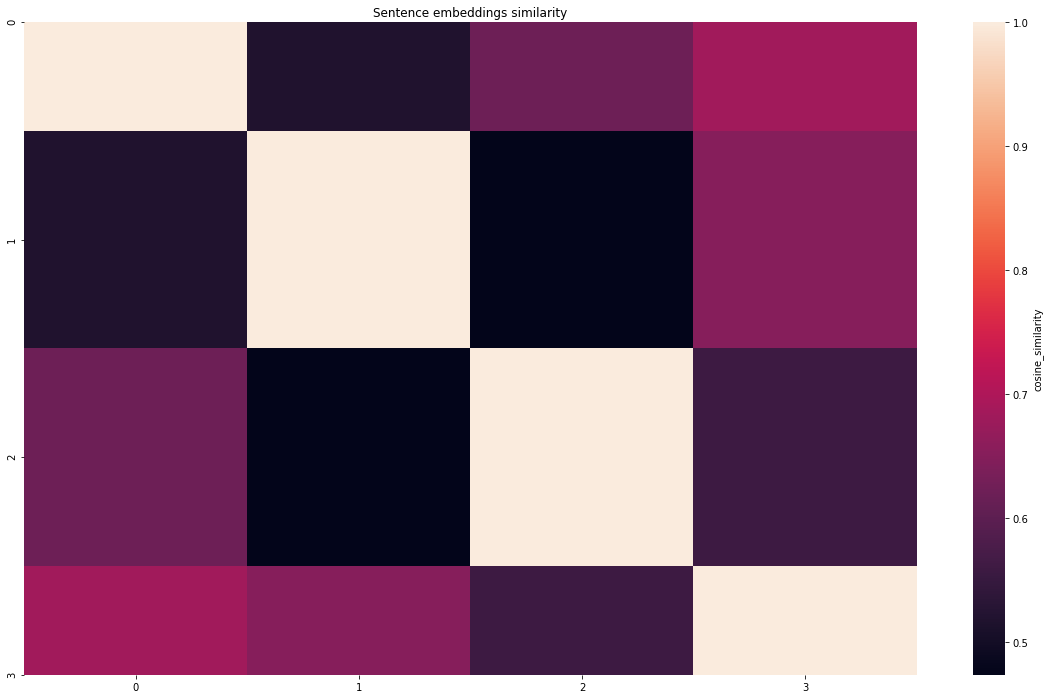

In [60]:
fig, ax = plt.subplots(figsize=(20, 12))

sns.heatmap(compute_distance_matrix(sentence_embeddings), cbar_kws={'label': 'cosine_similarity'})

_= ax.set_title("Sentence embeddings similarity")

In [42]:
all_tokens = [token for text in texts for token in tokenizer.tokenize(text)]

In [43]:
token_embeddings = token_embeddings_for_sequence(texts)

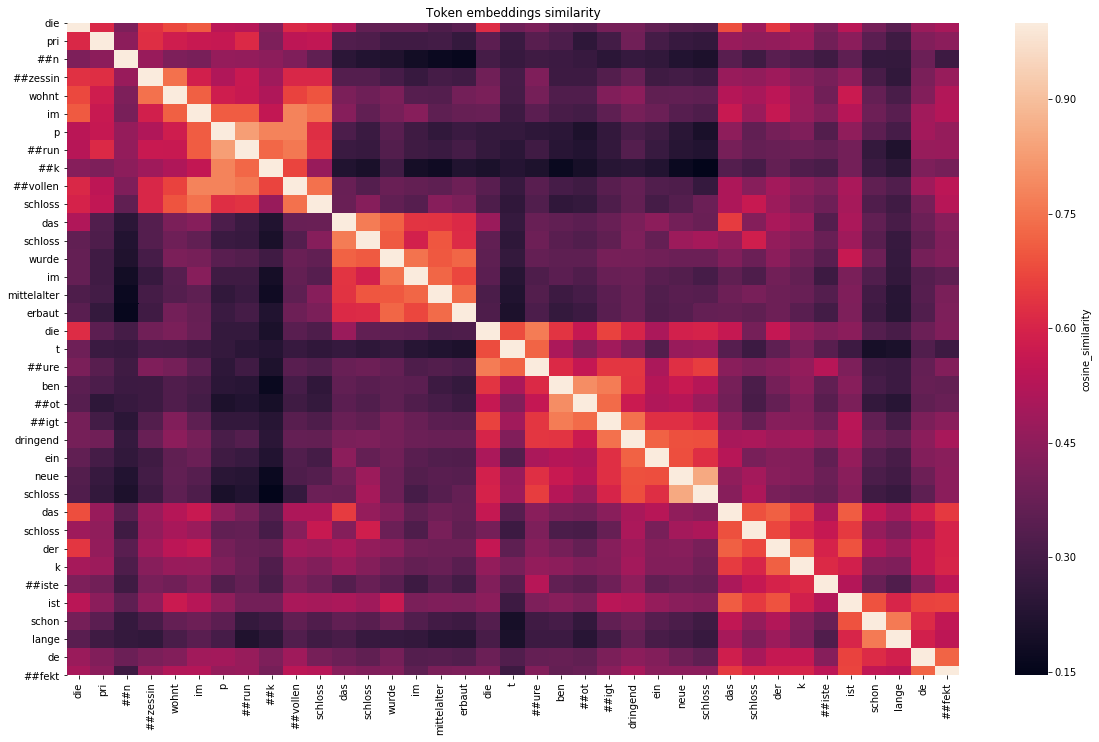

In [62]:
fig, ax = plt.subplots(figsize=(20, 12))
sns.heatmap(compute_distance_matrix(token_embeddings), 
            xticklabels=all_tokens, 
            yticklabels=all_tokens, 
            cbar_kws={'label': 'cosine_similarity'})

_= ax.set_title("Token embeddings similarity")

fig.savefig("token_embeddings_similarity.png")

In [53]:
keyword_embeddings = embeddings_for_keyword(texts, keyword)

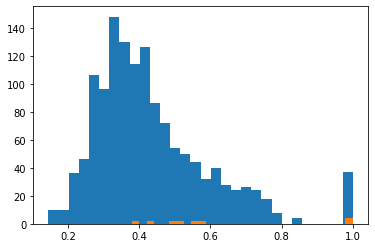

In [55]:
_ = plt.hist(compute_distance_matrix(token_embeddings).flatten(), 30)
_ = plt.hist(compute_distance_matrix(keyword_embeddings).flatten(), 30)